<a href="https://colab.research.google.com/github/bopeng-sue/Optimal-Biofluid-Matrices-for-Human-Exposome-Biomonitoring/blob/main/hyperparameter_xgboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import packages and file

In [ ]:
import numpy as np
import pandas as pd
from rdkit import Chem, RDLogger
from rdkit.Chem import AllChem, MACCSkeys, Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    balanced_accuracy_score,
    roc_auc_score,
    classification_report,
    roc_curve,
    precision_recall_curve,
    auc
)
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from tqdm import tqdm
from pathlib import Path
from imblearn.over_sampling import SMOTE
import warnings
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

warnings.filterwarnings('ignore')
RDLogger.DisableLog('rdApp.*')

In [ ]:
df = pd.read_excel('dataset_1211.xlsx')
df.head(2)

,Unnamed: 0,Biomonitor Compound PubChem CID,Blood study numbers,Urine study numbers,Tendency for the selection of blood samples,Biospecimen,CAS Number,Name,SMILES,hhlb(hours),...,JGI10,JGT,VE1_D,VE3_D,VR1_D,VR2_D,SRW5,AMW,WTPT-3,XLogP
0,0,70,0,2,0.0,Urine,816-66-0,4-Methyl-2-oxovaleric acid,CC(C)CC(=O)C(=O)O,0.61,...,0.0,0.601944,0.046505,-2.761367,35.180772,3.908975,0.0,6.845421,7.158910,0.904
1,1,89,0,1,0.0,Urine,484-78-6,Hydroxykynurenine,C1=CC(=C(C(=C1)O)N)C(=O)CC(C(=O)O)N,0.43,...,0.0,0.556317,0.130944,-3.252780,192.246721,12.015420,0.0,8.002847,14.772289,-2.464


# feature function

In [ ]:
def padel_descriptor(df: pd.DataFrame) -> np.ndarray:
    """
    Extracts Padel descriptors from a given DataFrame starting from column index 16
    to the end. It replaces NaN values with 0 and infinite values with 1e10.

    Parameters
    ----------
    df : pd.DataFrame
        The input DataFrame containing feature columns.

    Returns
    -------
    np.ndarray
        A NumPy array of transformed feature values.
    """
    # Slice columns from index 16 to the end
    X = df.iloc[:, 16:].values

    # Replace NaNs with 0
    X = np.nan_to_num(X, nan=0.0)

    # Replace infinities with a large finite value
    X[np.isinf(X)] = 1e10

    return X

In [ ]:
def maccs_descriptor(smiles_list):
    """
    Generates MACCS fingerprints for a list of SMILES strings and returns them as a DataFrame.

    Parameters
    ----------
    smiles_list : list of str
        A list of SMILES strings for which MACCS keys will be generated.

    Returns
    -------
    pd.DataFrame
        A DataFrame of MACCS bit values (0 or 1) with column names 'MACCS_1' through 'MACCS_167'.
    """
    # Generate MACCS fingerprints and convert them to a list of bits
    maccs_fingerprints = [
        list(MACCSkeys.GenMACCSKeys(Chem.MolFromSmiles(smiles)).ToBitString())
        for smiles in smiles_list
    ]

    # Convert the list of bits to a DataFrame
    # MACCSkeys are 167 bits long, hence 167 columns
    X = pd.DataFrame(maccs_fingerprints, columns=[f'MACCS_{i}' for i in range(1, 168)])

    # Convert strings to integers (0 and 1)
    X = X.astype(int)

    return X

In [ ]:
def ecfp_descriptor(smiles_list, radius=2, n_bits=1024):
    """
    Generates ECFP (Extended-Connectivity Fingerprints) for a list of SMILES strings
    and returns them as a NumPy array.

    Parameters
    ----------
    smiles_list : list of str
        A list of SMILES strings for which ECFP fingerprints will be generated.
    radius : int, optional (default=2)
        The fingerprint radius to use. For ECFP4, radius=2 is standard.
    n_bits : int, optional (default=1024)
        Length of the bit vector.

    Returns
    -------
    np.ndarray
        A 2D NumPy array where each row corresponds to the ECFP bit vector of the input SMILES.
    """
    def calculate_ecfp(smiles, radius=radius, n_bits=n_bits):
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=n_bits, useFeatures=False)
            return np.array(fp)
        else:
            return np.zeros(n_bits, dtype=int)

    # Apply ECFP calculation to the input list of SMILES
    ecfp_fingerprints = np.array([calculate_ecfp(s) for s in smiles_list])
    return ecfp_fingerprints

In [ ]:
def fcfp_descriptor(smiles_list, radius=2, n_bits=1024):
    """
    Generates FCFP (Feature-based Circular Fingerprints) for a list of SMILES strings
    and returns them as a NumPy array.

    Parameters
    ----------
    smiles_list : list of str
        A list of SMILES strings for which FCFP fingerprints will be generated.
    radius : int, optional (default=2)
        The fingerprint radius to use.
    n_bits : int, optional (default=1024)
        Length of the bit vector.

    Returns
    -------
    np.ndarray
        A 2D NumPy array where each row corresponds to the FCFP bit vector of the input SMILES.
    """
    def calculate_fcfp(smiles, radius=radius, n_bits=n_bits):
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=n_bits, useFeatures=True)
            return np.array(fp)
        else:
            return np.zeros(n_bits, dtype=int)

    # Apply FCFP calculation to the input list of SMILES
    fcfp_fingerprints = np.array([calculate_fcfp(s) for s in smiles_list])
    return fcfp_fingerprints

In [ ]:
def rdkit_descriptors_to_X(df: pd.DataFrame, smiles_col='SMILES', correlation_threshold=0.95) -> np.ndarray:
    """
    Compute RDKit molecular descriptors for each SMILES in the given DataFrame,
    remove descriptors with zero variance and highly correlated descriptors,
    and return the final feature matrix X.

    Parameters
    ----------
    df : pd.DataFrame
        A DataFrame containing at least a 'SMILES' column.
    smiles_col : str, optional
        The name of the column containing SMILES strings.
    correlation_threshold : float, optional
        Threshold above which descriptors are considered highly correlated and removed.

    Returns
    -------
    np.ndarray
        A 2D NumPy array containing the filtered RDKit descriptors.
    """
    # Convert SMILES to RDKit Mol objects
    mol_list = [Chem.MolFromSmiles(s) for s in df[smiles_col]]

    # Define the descriptor names
    descriptor_names = [desc_name[0] for desc_name in Descriptors._descList]

    # Create a descriptor calculator
    calculator = MoleculeDescriptors.MolecularDescriptorCalculator(descriptor_names)

    # Calculate descriptors for each molecule, if mol is None use NaNs
    descriptors_list = [
        calculator.CalcDescriptors(mol) if mol is not None else [np.nan]*len(descriptor_names)
        for mol in mol_list
    ]

    # Convert the list of descriptors to a DataFrame
    descriptors_df = pd.DataFrame(descriptors_list, columns=descriptor_names)

    # Replace NaNs with 0
    descriptors_df = descriptors_df.fillna(0)

    # Step 1: Remove descriptors with zero variance
    variance = descriptors_df.var()
    zero_variance_columns = variance[variance == 0].index
    descriptors_df = descriptors_df.drop(columns=zero_variance_columns)

    # Step 2: Remove descriptors with correlation exceeding the threshold
    corr = descriptors_df.corr().abs()
    to_drop = []

    for i, col1 in enumerate(corr.columns):
        for col2 in corr.columns[i+1:]:
            if corr.loc[col1, col2] > correlation_threshold:
                to_drop.append(col2)

    # Remove duplicates if any
    to_drop = list(set(to_drop))

    # Drop the highly correlated descriptors
    descriptors_df = descriptors_df.drop(columns=to_drop, errors='ignore')

    # Convert the final descriptors DataFrame to a NumPy array
    X = descriptors_df.values

    return X

# Hyperparameter_xgboost



Descriptor Processor

In [ ]:
def compute_descriptors(df: pd.DataFrame, descriptor_type: str, smiles_col: str='SMILES') -> np.ndarray:
    """
    Computes the specified molecular descriptor for the given DataFrame.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame containing at least the 'SMILES' column.
    descriptor_type : str
        Type of descriptor to compute. One of ['padel', 'maccs', 'ecfp', 'fcfp', 'rdkit'].
    smiles_col : str, optional
        Name of the column containing SMILES strings.

    Returns
    -------
    np.ndarray
        Feature matrix as a NumPy array.
    """
    if descriptor_type.lower() == 'padel':
        X = padel_descriptor(df)
    elif descriptor_type.lower() == 'maccs':
        X = maccs_descriptor(df[smiles_col].tolist()).values
    elif descriptor_type.lower() == 'ecfp':
        X = ecfp_descriptor(df[smiles_col].tolist())
    elif descriptor_type.lower() == 'fcfp':
        X = fcfp_descriptor(df[smiles_col].tolist())
    elif descriptor_type.lower() == 'rdkit':
        X = rdkit_descriptors_to_X(df, smiles_col=smiles_col, correlation_threshold=0.95)
    else:
        raise ValueError("Invalid descriptor_method. Choose from 'padel', 'maccs', 'fcfp', 'ecfp', 'rdkit'.")
    return X

Machine Learning Pipeline

In [ ]:
def run_ml_pipeline(
    X: np.ndarray,
    y: np.ndarray,
    descriptor_type: str,
    model_output_path: str='models/',
    max_evals: int=10000,
    random_state: int=42
) -> dict:
    """
    Runs the machine learning pipeline for a given descriptor type, trains the best model,
    evaluates it, plots ROC and PRC curves, saves the model, and returns performance metrics.

    Parameters
    ----------
    X : np.ndarray
        Feature matrix.
    y : np.ndarray
        Target vector.
    descriptor_type : str
        Descriptor type being processed.
    model_output_path : str, optional
        Directory path to save the models and plots. Defaults to 'models/'.
    max_evals : int, optional
        Number of evaluations for hyperparameter optimization. Defaults to 100.
    random_state : int, optional
        Random state for reproducibility. Defaults to 42.

    Returns
    -------
    dict
        A dictionary containing performance metrics.
    """
    # Create output directory if it doesn't exist
    Path(model_output_path).mkdir(parents=True, exist_ok=True)

    # ---------------------------
    # 1. Data Splitting
    # ---------------------------

    # Initialize the first split: train + temp (validation + test)
    sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=random_state)
    for train_index, temp_index in sss1.split(X, y):
        X_train, X_temp = X[train_index], X[temp_index]
        y_train, y_temp = y[train_index], y[temp_index]

    # Initialize the second split: validation + test from temp
    sss2 = StratifiedShuffleSplit(n_splits=1, test_size=2/3, random_state=random_state)  # 1/3 validation, 2/3 test
    for val_index, test_index in sss2.split(X_temp, y_temp):
        X_val, X_test = X_temp[val_index], X_temp[test_index]
        y_val, y_test = y_temp[val_index], y_temp[test_index]

    print(f"Dataset sizes for {descriptor_type}:")
    print(f"Training set: X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"Validation set: X_val: {X_val.shape}, y_val: {y_val.shape}")
    print(f"Test set: X_test: {X_test.shape}, y_test: {y_test.shape}")

    # ---------------------------
    # 2. Apply SMOTE
    # ---------------------------

    smote = SMOTE(random_state=random_state)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

    print(f"After SMOTE, training set sizes for {descriptor_type}:")
    print(f"X_train_res: {X_train_res.shape}, y_train_res: {y_train_res.shape}")

    # ---------------------------
    # 3. Hyperparameter Optimization with Hyperopt
    # ---------------------------

    # Define the objective function for XGBoost
    def objective_xgb(space):
        model = xgb.XGBClassifier(
            tree_method='gpu_hist',                # Enable GPU acceleration
            gpu_id=0,                              # Specify GPU ID (0 is default)
            max_depth=int(space['max_depth']),
            learning_rate=space['learning_rate'],
            n_estimators=int(space['n_estimators']),
            min_child_weight=int(space['min_child_weight']),
            subsample=space['subsample'],
            colsample_bytree=space['colsample_bytree'],
            gamma=space['gamma'],
            reg_alpha=space['reg_alpha'],          # L1 regularization
            reg_lambda=space['reg_lambda'],        # L2 regularization
            use_label_encoder=False,
            eval_metric='logloss',
            random_state=random_state,
            verbosity=0                            # Suppress training logs
        )

        model.fit(X_train_res, y_train_res)
        preds = model.predict(X_val)

        # Calculate metrics
        precision = precision_score(y_val, preds, average='binary')
        recall = recall_score(y_val, preds, average='binary')
        f1 = f1_score(y_val, preds, average='binary')
        balanced_acc = balanced_accuracy_score(y_val, preds)
        auc_score = roc_auc_score(y_val, model.predict_proba(X_val)[:,1])

        # You can choose which metric to optimize. Here, we use balanced accuracy
        # since it's more robust to class imbalance
        loss = -balanced_acc  # Hyperopt minimizes the loss

        return {'loss': loss, 'status': STATUS_OK}

    # Define the search space for XGBoost including L1 and L2 regularization
    space_xgb = {
        'max_depth': hp.quniform('max_depth', 3, 15, 1),
        'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.5)),
        'n_estimators': hp.quniform('n_estimators', 100, 1000, 1),
        'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
        'subsample': hp.uniform('subsample', 0.5, 1),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
        'gamma': hp.uniform('gamma', 0, 5),
        'reg_alpha': hp.loguniform('reg_alpha', np.log(1e-4), np.log(1.0)),   # L1
        'reg_lambda': hp.loguniform('reg_lambda', np.log(1e-4), np.log(1.0))  # L2
    }

    # Run the optimization for XGBoost
    trials_xgb = Trials()
    best_xgb = fmin(
        fn=objective_xgb,
        space=space_xgb,
        algo=tpe.suggest,
        max_evals=max_evals,                          # Adjust based on computational resources
        trials=trials_xgb,
        rstate=np.random.default_rng(random_state)      # Use Generator instead of RandomState
    )

    print(f"Best hyperparameters found for XGBoost ({descriptor_type}): ", best_xgb)

    # Convert hyperparameters to appropriate types
    best_params_xgb = {
        'tree_method': 'gpu_hist',               # Enable GPU acceleration
        'gpu_id': 0,                             # Specify GPU ID
        'max_depth': int(best_xgb['max_depth']),
        'learning_rate': best_xgb['learning_rate'],
        'n_estimators': int(best_xgb['n_estimators']),
        'min_child_weight': int(best_xgb['min_child_weight']),
        'subsample': best_xgb['subsample'],
        'colsample_bytree': best_xgb['colsample_bytree'],
        'gamma': best_xgb['gamma'],
        'reg_alpha': best_xgb['reg_alpha'],
        'reg_lambda': best_xgb['reg_lambda'],
        'use_label_encoder': False,
        'eval_metric': 'logloss',
        'random_state': random_state,
        'verbosity': 0                           # Suppress training logs
    }

    # ---------------------------
    # 4. Train the Best Model
    # ---------------------------

    best_model_xgb = xgb.XGBClassifier(**best_params_xgb)

    # Train the model on the resampled training set
    best_model_xgb.fit(X_train_res, y_train_res)

    # ---------------------------
    # 5. Evaluation on Test Set
    # ---------------------------

    y_pred_xgb = best_model_xgb.predict(X_test)
    y_proba_xgb = best_model_xgb.predict_proba(X_test)[:,1]

    # Calculate metrics
    precision = precision_score(y_test, y_pred_xgb, average='binary')
    recall = recall_score(y_test, y_pred_xgb, average='binary')
    f1 = f1_score(y_test, y_pred_xgb, average='binary')
    balanced_acc = balanced_accuracy_score(y_test, y_pred_xgb)
    auc_score = roc_auc_score(y_test, y_proba_xgb)

    print(f"\nXGBoost Model Performance on Test Set ({descriptor_type}):")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")
    print(f"AUC-ROC:   {auc_score:.4f}")

    # Detailed classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_xgb))

    # Per-class metrics
    precision_per_class = precision_score(y_test, y_pred_xgb, average=None)
    recall_per_class = recall_score(y_test, y_pred_xgb, average=None)
    f1_per_class = f1_score(y_test, y_pred_xgb, average=None)

    print("Precision per class:", precision_per_class)
    print("Recall per class:", recall_per_class)
    print("F1-Score per class:", f1_per_class)

    # ---------------------------
    # 6. Plotting ROC and Precision-Recall Curves (Optimized)
    # ---------------------------

    # Set seaborn style for a clean, academic look
    sns.set_style("white")  # Options include "white", "dark", "ticks", etc.

    # Choose a color palette that's colorblind-friendly and suitable for publications
    palette = sns.color_palette("colorblind")  # Alternatives: "deep", "muted", "pastel", etc.

    # Calculate ROC curve
    fpr, tpr, thresholds_roc = roc_curve(y_test, y_proba_xgb)
    roc_auc = auc(fpr, tpr)

    # Calculate Precision-Recall curve
    precision_vals, recall_vals, thresholds_prc = precision_recall_curve(y_test, y_proba_xgb)
    prc_auc = auc(recall_vals, precision_vals)

    # Set up the matplotlib figure with a larger size for better readability
    plt.figure(figsize=(14, 6))

    # ---------------------------
    # Plot ROC Curve
    # ---------------------------
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color=palette[0], lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--', label='Random Guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12, labelpad=10)
    plt.ylabel('True Positive Rate', fontsize=12, labelpad=10)
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14, pad=15)
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(False)  # Remove grid lines

    # ---------------------------
    # Plot Precision-Recall Curve
    # ---------------------------
    plt.subplot(1, 2, 2)
    plt.plot(recall_vals, precision_vals, color=palette[1], lw=2, label=f'PRC curve (AUC = {prc_auc:.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall', fontsize=12, labelpad=10)
    plt.ylabel('Precision', fontsize=12, labelpad=10)
    plt.title('Precision-Recall (PRC) Curve', fontsize=14, pad=15)
    plt.legend(loc="upper right", fontsize=12)
    plt.grid(False)  # Remove grid lines

    # Adjust layout for better spacing
    plt.tight_layout()

    # Save the figure with high resolution
    plot_filename = f'{model_output_path}/ROC_PRC_{descriptor_type}.png'
    plt.savefig(plot_filename, dpi=300, bbox_inches='tight')

    # Display the plot
    plt.show()
    print(f"ROC and PRC curves saved to {plot_filename}")

    # ---------------------------
    # 7. Save the Best Model
    # ---------------------------

    model_filename = f'{model_output_path}/best_xgb_model_{descriptor_type}.joblib'
    joblib.dump(best_model_xgb, model_filename)
    print(f"Best model saved to {model_filename}\n")

    # ---------------------------
    # 8. Compile Performance Metrics
    # ---------------------------

    results = {
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Balanced Accuracy': balanced_acc,
        'AUC-ROC': auc_score,
        'AUC-PRC': prc_auc,
        'Model Path': model_filename,
        'Plot Path': plot_filename
    }

    return results

# ---------------------------
# Descriptor Model Screening Function
# ---------------------------

def run_descriptor_model_screening(
    df: pd.DataFrame,
    target_col: str,
    smiles_col: str='SMILES',
    descriptor_method: str='padel',
    model_output_path: str='models/',
    max_evals: int=10000,
    random_state: int=42
) -> dict:
    """
    Runs the descriptor model screening for a given descriptor method.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame containing the data.
    target_col : str
        The name of the target column.
    smiles_col : str, optional
        The name of the SMILES column. Defaults to 'SMILES'.
    descriptor_method : str, optional
        The descriptor method to use. One of ['padel', 'maccs', 'fcfp', 'ecfp', 'rdkit'].
    model_output_path : str, optional
        Directory path to save the models and plots. Defaults to 'models/'.
    max_evals : int, optional
        Number of evaluations for hyperparameter optimization. Defaults to 100.
    random_state : int, optional
        Random state for reproducibility. Defaults to 42.

    Returns
    -------
    dict
        A dictionary containing performance metrics and paths.
    """
    print(f"Starting model screening for descriptor method: {descriptor_method}")

    # ---------------------------
    # 1. Extract and Binarize Target
    # ---------------------------
    y = (df[target_col] > 0.5).astype(int).values

    # ---------------------------
    # 2. Compute Features X
    # ---------------------------
    try:
        X = compute_descriptors(df, descriptor_type=descriptor_method, smiles_col=smiles_col)
    except ValueError as e:
        print(f"Error computing descriptors: {e}")
        return {}

    # ---------------------------
    # 3. Run Machine Learning Pipeline
    # ---------------------------
    results = run_ml_pipeline(
        X=X,
        y=y,
        descriptor_type=descriptor_method,
        model_output_path=model_output_path,
        max_evals=max_evals,
        random_state=random_state
    )

    return results

Main Execution Function

Starting model screening for descriptor method: padel
Dataset sizes for padel:
Training set: X_train: (321, 664), y_train: (321,)
Validation set: X_val: (71, 664), y_val: (71,)
Test set: X_test: (144, 664), y_test: (144,)
After SMOTE, training set sizes for padel:
X_train_res: (396, 664), y_train_res: (396,)
100%|██████████| 2000/2000 [21:36<00:00,  1.54trial/s, best loss: -0.9545454545454546]
Best hyperparameters found for XGBoost (padel):  {'colsample_bytree': 0.9075108426142208, 'gamma': 0.9329643305855009, 'learning_rate': 0.31394930211745786, 'max_depth': 6.0, 'min_child_weight': 6.0, 'n_estimators': 733.0, 'reg_alpha': 0.2217596064056233, 'reg_lambda': 0.0004762446662580158, 'subsample': 0.6101098588379696}

XGBoost Model Performance on Test Set (padel):
Precision: 0.9341
Recall:    0.9659
F1-Score:  0.9497
Balanced Accuracy: 0.9294
AUC-ROC:   0.9801

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.89      0.92        5

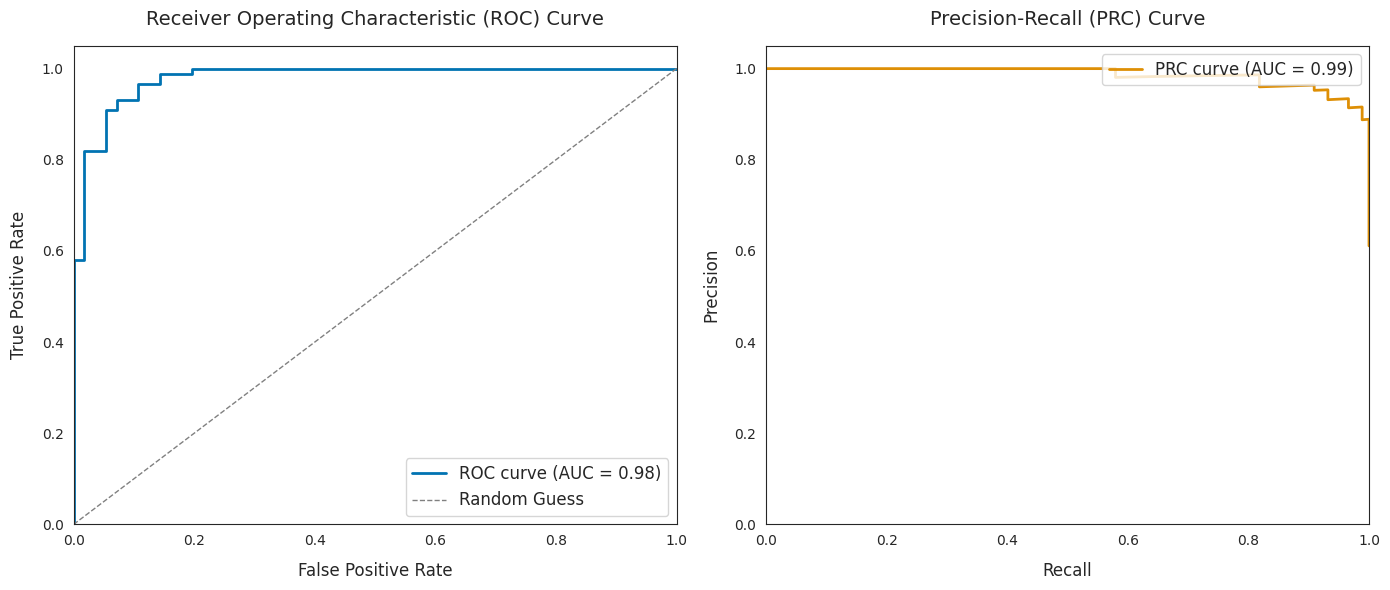

ROC and PRC curves saved to models//ROC_PRC_padel.png
Best model saved to models//best_xgb_model_padel.joblib

Starting model screening for descriptor method: maccs
Dataset sizes for maccs:
Training set: X_train: (321, 167), y_train: (321,)
Validation set: X_val: (71, 167), y_val: (71,)
Test set: X_test: (144, 167), y_test: (144,)
After SMOTE, training set sizes for maccs:
X_train_res: (396, 167), y_train_res: (396,)
100%|██████████| 2000/2000 [24:12<00:00,  1.38trial/s, best loss: -0.9545454545454546]
Best hyperparameters found for XGBoost (maccs):  {'colsample_bytree': 0.9767096474090495, 'gamma': 1.2055776014398167, 'learning_rate': 0.495636703082932, 'max_depth': 4.0, 'min_child_weight': 2.0, 'n_estimators': 749.0, 'reg_alpha': 0.00020970155126763995, 'reg_lambda': 0.00025091944941567715, 'subsample': 0.6953105858585952}

XGBoost Model Performance on Test Set (maccs):
Precision: 0.8400
Recall:    0.9545
F1-Score:  0.8936
Balanced Accuracy: 0.8344
AUC-ROC:   0.9185

Classification R

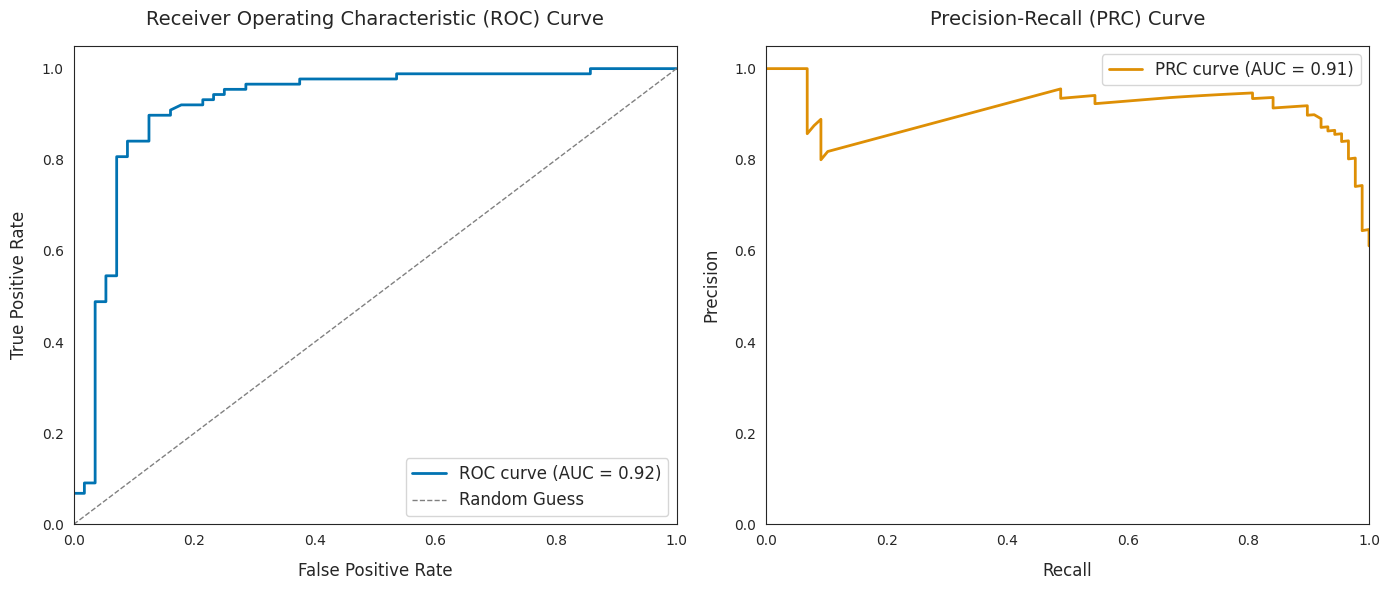

ROC and PRC curves saved to models//ROC_PRC_maccs.png
Best model saved to models//best_xgb_model_maccs.joblib

Starting model screening for descriptor method: fcfp
Dataset sizes for fcfp:
Training set: X_train: (321, 1024), y_train: (321,)
Validation set: X_val: (71, 1024), y_val: (71,)
Test set: X_test: (144, 1024), y_test: (144,)
After SMOTE, training set sizes for fcfp:
X_train_res: (396, 1024), y_train_res: (396,)
100%|██████████| 2000/2000 [31:54<00:00,  1.04trial/s, best loss: -0.9061447811447811]
Best hyperparameters found for XGBoost (fcfp):  {'colsample_bytree': 0.5139175178538465, 'gamma': 0.4552874747197794, 'learning_rate': 0.0708348173405986, 'max_depth': 9.0, 'min_child_weight': 3.0, 'n_estimators': 723.0, 'reg_alpha': 0.00012339934523499278, 'reg_lambda': 0.002115651271909386, 'subsample': 0.7957619167355511}

XGBoost Model Performance on Test Set (fcfp):
Precision: 0.8817
Recall:    0.9318
F1-Score:  0.9061
Balanced Accuracy: 0.8677
AUC-ROC:   0.9505

Classification Rep

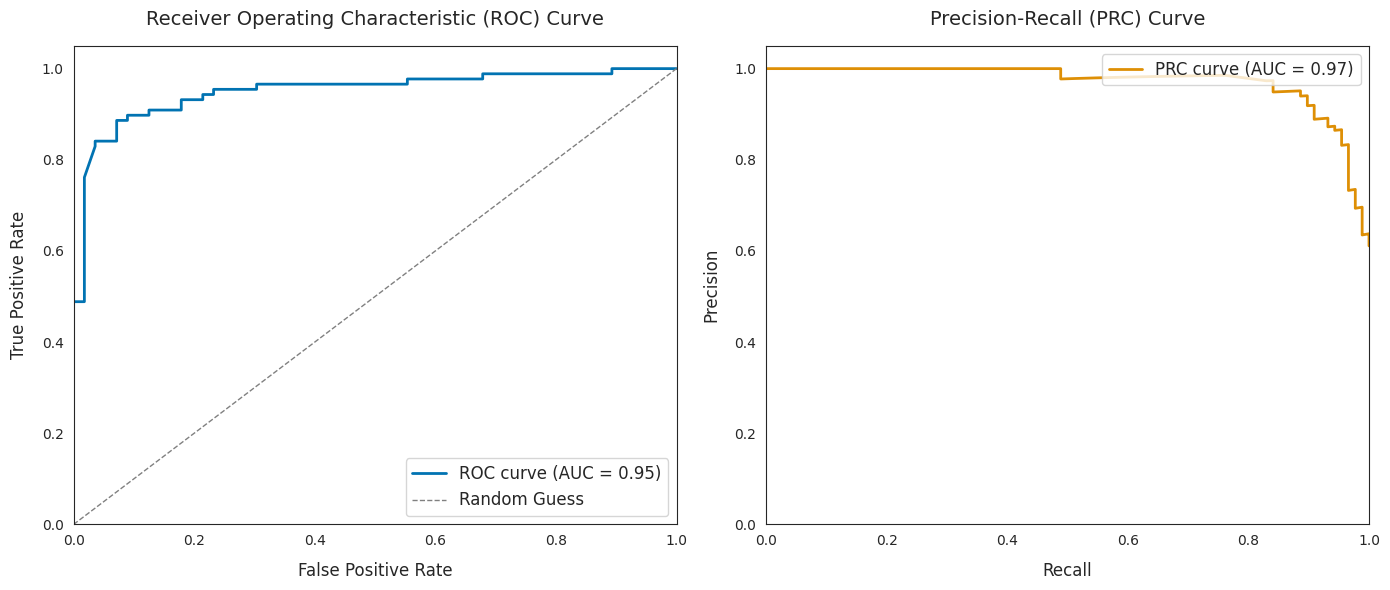

ROC and PRC curves saved to models//ROC_PRC_fcfp.png
Best model saved to models//best_xgb_model_fcfp.joblib

Starting model screening for descriptor method: ecfp
Dataset sizes for ecfp:
Training set: X_train: (321, 1024), y_train: (321,)
Validation set: X_val: (71, 1024), y_val: (71,)
Test set: X_test: (144, 1024), y_test: (144,)
After SMOTE, training set sizes for ecfp:
X_train_res: (396, 1024), y_train_res: (396,)
100%|██████████| 2000/2000 [21:48<00:00,  1.53trial/s, best loss: -0.9473905723905723]
Best hyperparameters found for XGBoost (ecfp):  {'colsample_bytree': 0.7992282876360194, 'gamma': 0.46588616062689514, 'learning_rate': 0.168974030541456, 'max_depth': 11.0, 'min_child_weight': 1.0, 'n_estimators': 528.0, 'reg_alpha': 0.0028684277017900187, 'reg_lambda': 0.001152733442143944, 'subsample': 0.5370047756435194}

XGBoost Model Performance on Test Set (ecfp):
Precision: 0.9111
Recall:    0.9318
F1-Score:  0.9213
Balanced Accuracy: 0.8945
AUC-ROC:   0.9629

Classification Repor

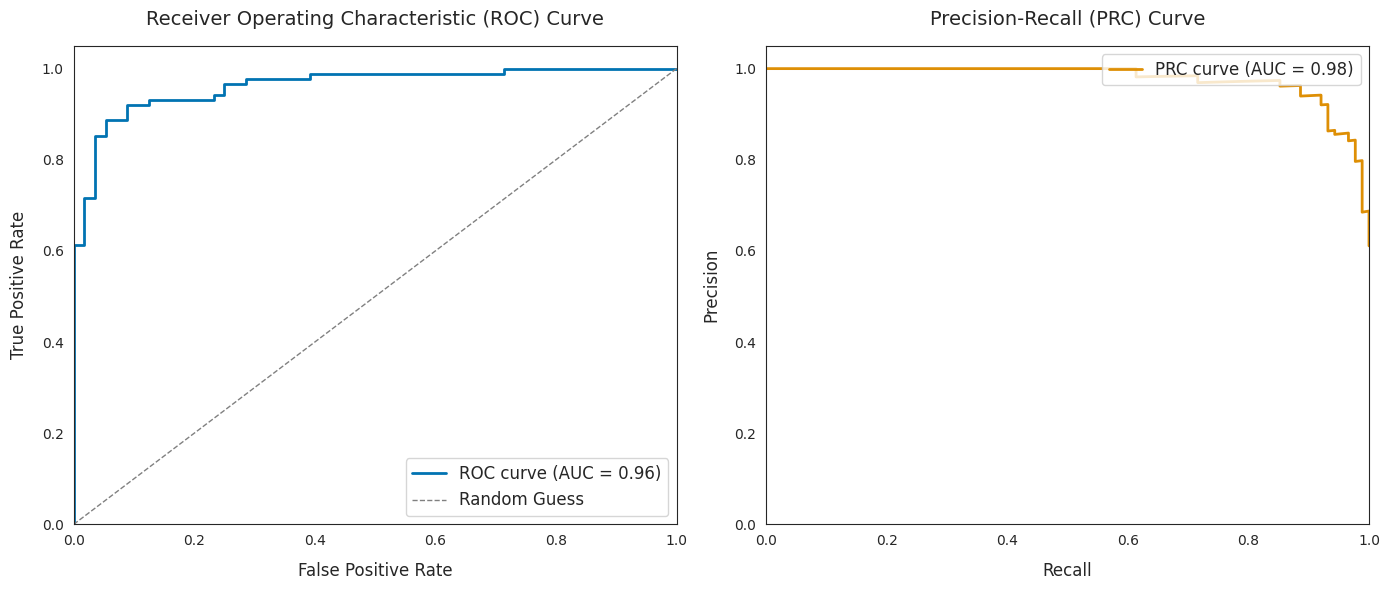

ROC and PRC curves saved to models//ROC_PRC_ecfp.png
Best model saved to models//best_xgb_model_ecfp.joblib

Starting model screening for descriptor method: rdkit
Dataset sizes for rdkit:
Training set: X_train: (321, 145), y_train: (321,)
Validation set: X_val: (71, 145), y_val: (71,)
Test set: X_test: (144, 145), y_test: (144,)
After SMOTE, training set sizes for rdkit:
X_train_res: (396, 145), y_train_res: (396,)
100%|██████████| 2000/2000 [17:03<00:00,  1.95trial/s, best loss: -0.9545454545454546]
Best hyperparameters found for XGBoost (rdkit):  {'colsample_bytree': 0.9983270594947024, 'gamma': 1.0742421685395969, 'learning_rate': 0.3498522444807185, 'max_depth': 6.0, 'min_child_weight': 3.0, 'n_estimators': 471.0, 'reg_alpha': 0.0013287604302755084, 'reg_lambda': 0.07240781758609195, 'subsample': 0.8962820191065113}

XGBoost Model Performance on Test Set (rdkit):
Precision: 0.8901
Recall:    0.9205
F1-Score:  0.9050
Balanced Accuracy: 0.8709
AUC-ROC:   0.9679

Classification Report

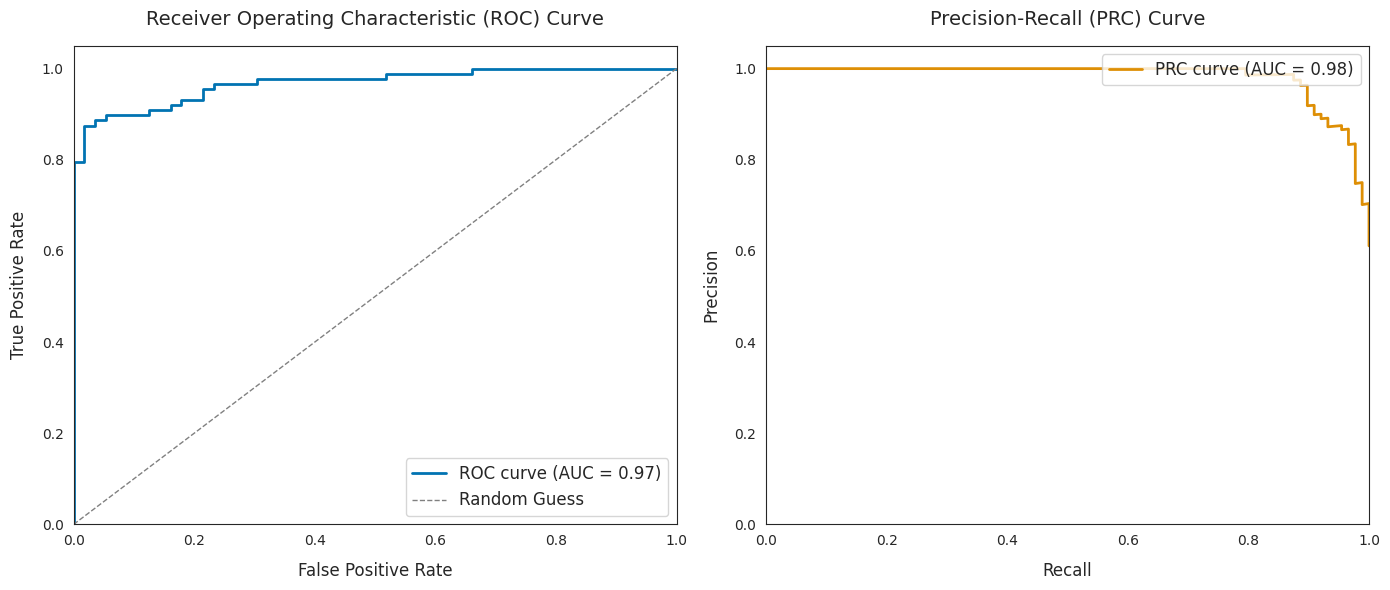

ROC and PRC curves saved to models//ROC_PRC_rdkit.png
Best model saved to models//best_xgb_model_rdkit.joblib

All results saved to models/all_descriptor_results.csv

Summary of All Descriptor Methods:
      Precision    Recall  F1-Score Balanced Accuracy   AUC-ROC   AUC-PRC  \
padel  0.934066  0.965909  0.949721          0.929383  0.980114   0.98613   
maccs      0.84  0.954545  0.893617          0.834416  0.918527  0.906072   
fcfp    0.88172  0.931818  0.906077          0.867695  0.950487  0.971467   
ecfp   0.911111  0.931818  0.921348          0.894481  0.962865  0.977769   
rdkit   0.89011  0.920455  0.905028          0.870942  0.967938  0.982421   

                                Model Path                  Plot Path  
padel  models//best_xgb_model_padel.joblib  models//ROC_PRC_padel.png  
maccs  models//best_xgb_model_maccs.joblib  models//ROC_PRC_maccs.png  
fcfp    models//best_xgb_model_fcfp.joblib   models//ROC_PRC_fcfp.png  
ecfp    models//best_xgb_model_ecfp.joblib   mo

In [ ]:
def main():
    """
    Main function to execute the machine learning pipeline for each descriptor type.
    """

    # Define descriptor methods you want to test
    descriptor_methods = ['padel', 'maccs', 'fcfp', 'ecfp', 'rdkit']

    # Dictionary to store the results for each descriptor method
    all_results = {}

    for method in descriptor_methods:
        results = run_descriptor_model_screening(
            df=df,
            target_col='Tendency for the selection of blood samples',
            smiles_col='SMILES',
            descriptor_method=method,
            model_output_path='models/',       # Ensure this directory exists or is created
            max_evals=2000,                     # Adjust based on computational resources
            random_state=42
        )
        all_results[method] = results

    # ---------------------------
    # 4. Save All Results to a CSV
    # ---------------------------

    results_df = pd.DataFrame(all_results).T  # Transpose for better readability
    results_csv_path = 'models/all_descriptor_results.csv'
    results_df.to_csv(results_csv_path)
    print(f"All results saved to {results_csv_path}")

    # ---------------------------
    # 5. Display Summary
    # ---------------------------

    print("\nSummary of All Descriptor Methods:")
    print(results_df)

if __name__ == "__main__":
    main()
